In [1]:
import urllib.request
import json
import numpy as np
import pandas as pd
from joblib import load
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
def custom_analyzer(doc):
    return doc

cardVec = load('matrix_data/cardVec_8k_20dim.joblib')
deckVecorizer = load('matrix_data/deckVectorizer_8k_30K.joblib')

In [3]:
deckVecorizer

TfidfVectorizer(analyzer=<function custom_analyzer at 0x000002AC22DA4280>,
                lowercase=False,
                vocabulary=['Strike_R', 'Bash', 'Anger', 'Body Slam', 'Clash',
                            'Cleave', 'Clothesline', 'Headbutt', 'Heavy Blade',
                            'Iron Wave', 'Perfected Strike', 'Pommel Strike',
                            'Sword Boomerang', 'Thunderclap', 'Twin Strike',
                            'Wild Strike', 'Blood for Blood', 'Carnage',
                            'Dropkick', 'Hemokinesis', 'Pummel', 'Rampage',
                            'Reckless Charge', 'Searing Blow', 'Sever Soul',
                            'Uppercut', 'Whirlwind', 'Bludgeon', 'Feed',
                            'Fiend Fire', ...])

In [4]:
data_url = 'https://raw.githubusercontent.com/KU81-ComSci-ProjectEnd-GameCard/main/master/Predictor/data/processed_data/picked_8k_30k.json'
with urllib.request.urlopen(data_url) as url:
    pick_js = json.loads(url.read().decode())
pick = pd.DataFrame(pick_js)

In [5]:
pick

,deck,picked
0,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",Bludgeon
1,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",Flex
2,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",Anger
3,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",Reckless Charge
4,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",Flex
...,...,...
30225,"[Strike_R+1, Strike_R+1, Strike_R+1, Strike_R+...",Shrug It Off+1
30226,"[Strike_R+1, Strike_R+1, Strike_R+1, Strike_R+...",Headbutt+1
30227,"[Strike_R+1, Strike_R+1, Strike_R+1, Strike_R+...",Shockwave+1
30228,"[Strike_R+1, Strike_R+1, Strike_R+1, Strike_R+...",Clothesline


kerass

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

In [28]:
X = deckVecorizer.fit_transform(pick.deck.tolist())
X = X.toarray()
y = [cardVec[picked] for picked in pick.picked ]
y_card = pick.picked 

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
y_card = np.array(y_card, dtype= str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test, yC_train,yC_test = train_test_split(X, y,y_card, test_size=0.2, random_state=82)

In [29]:
X.shape

(30230, 257)

In [30]:
y.shape

(30230, 20)

In [31]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
def cosine_similarity_loss(y_true, y_pred):
    # Compute the dot product between y_true and y_pred
    dot_product = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=-1)
    
    # Compute the norm of y_true and y_pred
    norm_y_true = tf.sqrt(tf.reduce_sum(tf.square(y_true), axis=-1))
    norm_y_pred = tf.sqrt(tf.reduce_sum(tf.square(y_pred), axis=-1))
    
    # Compute cosine similarity
    cosine_similarity = dot_product / (norm_y_true * norm_y_pred + tf.keras.backend.epsilon())
    
    # Cosine similarity ranges from -1 to 1, so we convert it to a loss value by subtracting from 1
    return 1 - cosine_similarity

In [33]:
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    similarity = dot_product / (norm1 * norm2)
    return similarity

In [43]:
model = Sequential([
    Input(shape=(257,)),# Define the input shape

    Dense(256,activation='relu' ,  kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu' ,  kernel_regularizer=l2(0.001)),     
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu' ,  kernel_regularizer=l2(0.001)),      
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(32, activation='relu' ,  kernel_regularizer=l2(0.001)), 
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(20)           
])
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss= cosine_similarity_loss, metrics=['mae','cosine_similarity']) 

In [44]:
class PrintLossEveryTenEpochs(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 1 == 0:
            print(f'Epoch {epoch + 1}, Loss: {logs["loss"]:.4f}')

In [45]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32,validation_split=0.2, verbose=0, callbacks=[PrintLossEveryTenEpochs()])

Epoch 1, Loss: 0.8852
Epoch 2, Loss: 0.4312
Epoch 3, Loss: 0.3027
Epoch 4, Loss: 0.2714
Epoch 5, Loss: 0.2678
Epoch 6, Loss: 0.2663
Epoch 7, Loss: 0.2656
Epoch 8, Loss: 0.2669
Epoch 9, Loss: 0.2672
Epoch 10, Loss: 0.2665


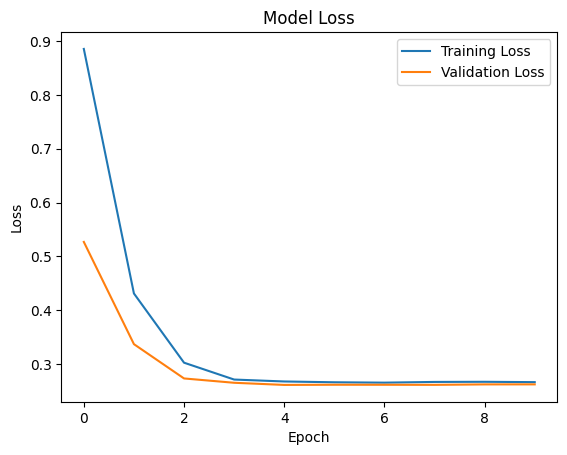

In [46]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

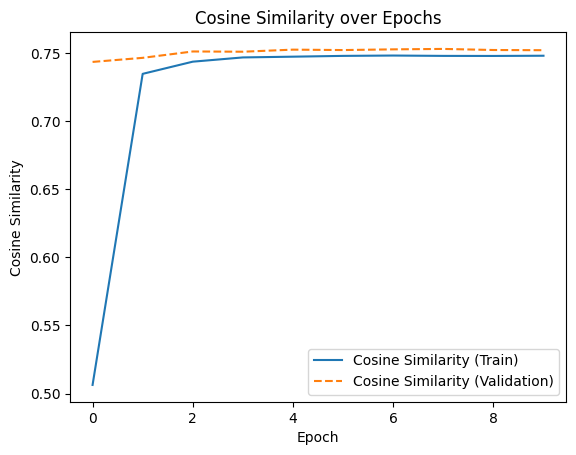

In [47]:
# Extract values for custom metric
cosine_similarity_values = history.history['cosine_similarity']
val_cosine_similarity_values = history.history.get('val_cosine_similarity', [])

# Extract values for loss and validation loss if needed
loss_values = history.history['loss']
val_loss_values = history.history.get('val_loss', [])

plt.plot(cosine_similarity_values, label='Cosine Similarity (Train)')
if val_cosine_similarity_values:
    plt.plot(val_cosine_similarity_values, label='Cosine Similarity (Validation)', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity over Epochs')
plt.legend()
plt.show()

In [39]:

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test, verbose=1)

# If loss is a list, print the first element as the test loss
print(f'Test Loss: {loss[0]:.4f}' if isinstance(loss, list) else f'Test Loss: {loss:.4f}')

# Make predictions (optional)
predictions = model.predict(X_test)
simility_test = list()
for pred, pick_card in zip(predictions , yC_test):
    simility_test.append(cosine_similarity(pred, cardVec[pick_card]))

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - cosine_similarity: 0.7494 - loss: 0.2646 - mae: 1.0192
Test Loss: 0.2632
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [40]:
mt = pd.DataFrame()

In [41]:
mt['similate'] = simility_test

In [42]:
mt['similate'] = simility_test
mt.similate.describe()

count    6046.000000
mean        0.750849
std         0.154307
min         0.254030
25%         0.654775
50%         0.797872
75%         0.870980
max         0.963795
Name: similate, dtype: float64